# Линейная регрессия: прогноз оклада по описанию вакансии

###### Импорт необходимых библиотек

In [74]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt

###### Импорт датасета и предобработка данных 

In [5]:
data_train = pd.read_csv('salary-train.csv')
data_train.head(5)

,FullDescription,LocationNormalized,ContractTime,SalaryNormalized
0,International Sales Manager London ****k ****...,London,permanent,33000
1,An ideal opportunity for an individual that ha...,London,permanent,50000
2,Online Content and Brand Manager// Luxury Reta...,South East London,permanent,40000
3,A great local marketleader is seeking a perman...,Dereham,permanent,22500
4,Registered Nurse / RGN Nursing Home for Young...,Sutton Coldfield,NaN,20355


In [10]:
# приведение описаний вакансий к нижнему регистру
data_train['FullDescription'] = data_train['FullDescription'].apply(lambda x: x.lower())
# замена любых символов, отличных от букв и цифр, на пробелы
data_train['FullDescription'] = data_train['FullDescription'].replace('[^a-zA-Z0-9]', ' ', regex=True)

In [11]:
# проверка, что описания вакансий изменились
data_train.head(5)

,FullDescription,LocationNormalized,ContractTime,SalaryNormalized
0,international sales manager london k ...,London,permanent,33000
1,an ideal opportunity for an individual that ha...,London,permanent,50000
2,online content and brand manager luxury reta...,South East London,permanent,40000
3,a great local marketleader is seeking a perman...,Dereham,permanent,22500
4,registered nurse rgn nursing home for young...,Sutton Coldfield,NaN,20355


In [14]:
# Преобразование описаний вакансий в векторы признака
vectorizer = TfidfVectorizer(min_df=5)
X_Description = vectorizer.fit_transform(data_train['FullDescription'])

In [18]:
# Замена пропусков в столбцах на строку "nan"
data_train['LocationNormalized'].fillna('nan', inplace=True)
data_train['ContractTime'].fillna('nan', inplace=True)
# Преобразование двух столбцов из категориальных признаков в бинарные
encoder = DictVectorizer()
X_Category = encoder.fit_transform(data_train[['LocationNormalized', 'ContractTime']].to_dict(orient='records'))

In [29]:
# Образование выборки путем совмещения векторов описаний вакансий с обработанными категориальными признаками
X_train = hstack([X_Description, X_Category])
y_train = data_train['SalaryNormalized']
print('Размер векторов описаний вакансий:', X_Description.shape)
print('Размер измененных категориальных признаков:', X_Category.shape)
print('Размер обработанной выборки:', X_train.shape)
print('Разница в столбцах:', (X_Description.shape[1] + X_Category.shape[1]) - X_train.shape[1])

Размер векторов описаний вакансий: (60000, 22861)
Размер измененных категориальных признаков: (60000, 1766)
Размер обработанной выборки: (60000, 24627)
Разница в столбцах: 0


###### Создание и обучение гребневой регрессии 

In [31]:
RidgeRegressor = Ridge(alpha=1.0, random_state=241)
RidgeRegressor.fit(X_train, y_train)

Ridge(random_state=241)

###### Прогнозирование на нескольких примерах при помощи обученной регрессии

In [52]:
df_test1 = pd.read_csv('salary-test-mini.csv')

In [53]:
# преобразования признаков
df_test1['FullDescription'] = df_test1['FullDescription'].apply(lambda x: x.lower())
df_test1['FullDescription'] = df_test1['FullDescription'].replace('[^a-zA-Z0-9]', ' ', regex=True)
X_test1_Description = vectorizer.transform(df_test1['FullDescription'])

X_test1_Category = encoder.transform(df_test1[['LocationNormalized', 'ContractTime']].to_dict(orient='records'))
X_test1 = hstack([X_test1_Description, X_test1_Category])

In [54]:
predictions = RidgeRegressor.predict(X_test1)

In [55]:
df_test1['SalaryNormalized'] = list(map(lambda x: round(x, 2), predictions))
df_test1

,FullDescription,LocationNormalized,ContractTime,SalaryNormalized
0,we currently have a vacancy for an hr project ...,Milton Keynes,contract,56576.52
1,a web developer opportunity has arisen with an...,Manchester,permanent,37136.22


###### Оценка качества гребневой регрессии при различных $\alpha$

In [97]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
alphas = np.arange(0.1, 11.0, 1.0)
scores = []
for alpha in alphas:
    score = cross_val_score(Ridge(alpha=alpha), X_train, y_train, scoring='r2', cv=cv).mean()
    scores.append(score)

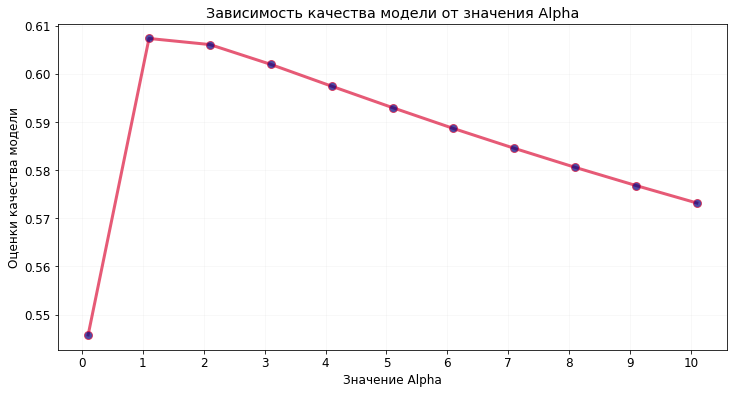

In [98]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,6))
plt.plot(alphas, scores, marker='o', color='crimson', ms=8.0,  markerfacecolor='navy', lw=3.0, alpha=0.7)
plt.xticks(np.arange(0, 11))
plt.grid(alpha=0.1)
plt.xlabel('Значение Alpha')
plt.ylabel('Оценки качества модели')
plt.title('Зависимость качества модели от значения Alpha')
plt.show()

Таким образом, из графика видно, что было выбрано оптимальное значение $\alpha$ при данной модели и обработанных данных.